## 目的：あるクラウドファンディングが成功するかを事前に予測するモデルを構築する

In [35]:
import markdown
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### データの可視化、前処理

In [36]:
#データの読み込み
df = pd.read_csv("ks-projects-201801.csv")
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [37]:
#データの確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [38]:
#データの統計量の確認
df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [39]:
#欠損値の確認
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [40]:
#'category', 'main_category'が何種類あるのかの確認
df[['category', 'main_category']].nunique()

category         159
main_category     15
dtype: int64

In [41]:
#'main_category'のそれぞれのカテゴリに何個あるのかの確認
df['main_category'].value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [42]:
#'state'のそれぞれのカテゴリに何個あるのかの確認
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [43]:
#'state'列が'failed'と'successful'だけのデータを残し、データを数値に変換
df = df[(df['state'] == 'failed' ) | (df['state'] == 'successful')]
df['state'] = df['state'].map({
    'failed':0,
    'successful':1
})
df['state'].value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [44]:
#クラウドファンディングの期間を新たな説明変数に加える

#'deadline'と'launched'を変換
df['deadline'] = pd.to_datetime(df['deadline'], format = '%Y-%m-%d %H:%M:%S')
df['launched'] = pd.to_datetime(df['launched'], format = '%Y-%m-%d %H:%M:%S')

#クラウドファンディングの期間を表す説明変数'period'を導入
df['period'] = (df['deadline'] - df['launched']).dt.days

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00,34


In [45]:
#不要なデータと予測する段階で知り得ないデータを除外
df = df.drop(columns=['ID','name', 'deadline', 'goal', 'launched', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'])
df.head()

,category,main_category,currency,state,country,usd_goal_real,period
0,Poetry,Publishing,GBP,0,GB,1533.95,58
1,Narrative Film,Film & Video,USD,0,US,30000.00,59
2,Narrative Film,Film & Video,USD,0,US,45000.00,44
3,Music,Music,USD,0,US,5000.00,29
5,Restaurants,Food,USD,1,US,50000.00,34


In [46]:
#欠損値の確認
df.isnull().sum()

category         0
main_category    0
currency         0
state            0
country          0
usd_goal_real    0
period           0
dtype: int64

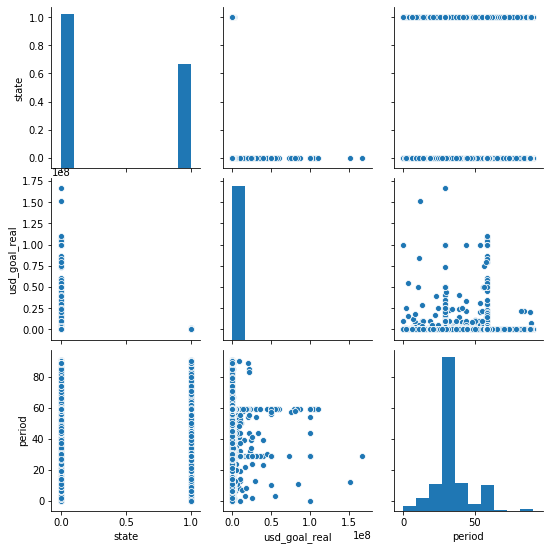

In [31]:
#全ての量的変数に対して散布図行列を表示
sns.pairplot(df)
plt.show()

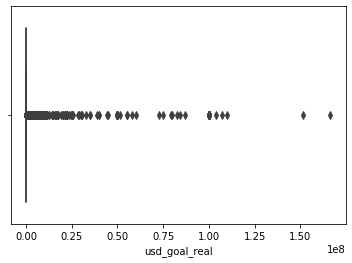

In [30]:
#'usd_goal_real'列のデータの確認
sns.boxplot(df.usd_goal_real)
plt.show()

In [50]:
#カテゴリ変数をダミー変数に置き換える
df = pd.get_dummies(df, columns=['category', 'main_category', 'currency', 'country'])
df.head()

,state,usd_goal_real,period,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,1533.95,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30000.00,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,50000.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
#データの確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Columns: 214 entries, state to country_US
dtypes: float64(1), int64(2), uint8(211)
memory usage: 86.9 MB


### ランダムフォレストを実装

In [63]:
#ホールドアウト法の実装
#ホールドアウト法に関する関数をimport
from sklearn.model_selection import train_test_split

y = df['state'].values
X = df.drop('state', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)

#ランダムフォレストを実装
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=1234)

clf.fit(X_train, y_train)

#訓練データとテストデータに対する精度を表示
print("訓練データに対する精度：{:.3f}".format(clf.score(X_train, y_train)))
print("テストデータに対する精度：{:.3f}".format(clf.score(X_test, y_test)))

訓練データに対する精度：0.836
テストデータに対する精度：0.648


In [67]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

#テストデータに対する結果を格納
y_est = clf.predict(X_test)

#混同行列を作成
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est),
                       index=['正解 = クラウドファンディング失敗', '正解 = クラウドファンディング成功'],
                       columns=['予測 = クラウドファンディング失敗', '予測 = クラウドファンディング成功']
                       )
conf_mat

,予測 = クラウドファンディング失敗,予測 = クラウドファンディング成功
正解 = クラウドファンディング失敗,29840,9888
正解 = クラウドファンディング成功,13486,13121


In [68]:
# 正解率(Accuracy)を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

#Recall,Precision,F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# クラウドファンディング成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率(Accuracy) = 64.764%
適合率（Precision） = 57.026%
再現率（Recall） = 49.314%
F1値（F1-score） = 52.890%


### 交差検証によるパラメータチューニングを行う

In [69]:
#'GridSearchCV'クラスをインポート
from sklearn.model_selection import GridSearchCV

y = df['state'].values
X = df.drop('state', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)

#パラメータを指定
parameters = {'min_samples_leaf':[1,3,5], 'min_samples_split':[2,4,6]}

clf = RandomForestClassifier(n_estimators=10, random_state=1234)
grid_search = GridSearchCV(clf, parameters, cv = 3)

grid_search.fit(X_train, y_train)

print("テストデータに対する精度：{:.3f}".format(grid_search.score(X_test, y_test)))

テストデータに対する精度：0.677


In [70]:
#最良のパラメータと交差検証スコアを表示
print("best parameters:{}".format(grid_search.best_params_))
print("best cross-validation score:{:.3f}".format(grid_search.best_score_))

best parameters:{'min_samples_leaf': 5, 'min_samples_split': 2}
best cross-validation score:0.675


In [72]:
#最適なパラメータでモデルを訓練
clf2 = RandomForestClassifier(**grid_search.best_params_, n_estimators=10, random_state=1234)
clf2.fit(X_train, y_train)

#訓練データとテストデータに対する精度を表示
print("訓練データに対する精度：{:.3f}".format(clf2.score(X_train, y_train)))
print("テストデータに対する精度：{:.3f}".format(clf2.score(X_test, y_test)))

訓練データに対する精度：0.719
テストデータに対する精度：0.677


In [73]:
#テストデータに対する結果を格納
y_est = clf2.predict(X_test)

#混同行列を作成
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est),
                       index=['正解 = クラウドファンディング失敗', '正解 = クラウドファンディング成功'],
                       columns=['予測 = クラウドファンディング失敗', '予測 = クラウドファンディング成功']
                       )
conf_mat

,予測 = クラウドファンディング失敗,予測 = クラウドファンディング成功
正解 = クラウドファンディング失敗,31681,8047
正解 = クラウドファンディング成功,13409,13198


In [74]:
# 正解率(Accuracy)を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

#Recall,Precision,F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# クラウドファンディング成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率(Accuracy) = 67.655%
適合率（Precision） = 62.123%
再現率（Recall） = 49.603%
F1値（F1-score） = 55.162%
